In [1]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools
import sklearn.cluster

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade

from chofer_tda_datasets import Reininghaus2014ShrecReal
from chofer_tda_datasets.transforms import Hdf5GroupToDict

from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit


%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 150
    lr_initial = 0.8
    momentum = 0.9
    lr_epoch_step = 20
    batch_size = 20
    train_size = 0.9
    minimal_distance_from_diagonal = 0.00001
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)

def filter_out_diagonal_points(x):
    def fn(dgm):
        i = ((dgm[:, 1] - dgm[:, 0]) > train_env.minimal_distance_from_diagonal).nonzero().squeeze()
        if len(i) == 0:
            return torch.Tensor([])
        else:             
            return dgm[i]
    
    
    return collection_cascade(x, lambda xx: isinstance(xx, torch._TensorBase), fn)


dataset = Reininghaus2014ShrecReal(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')
dataset.data_transforms = [
                           Hdf5GroupToDict(),
                           numpy_to_torch_cascade,   
                           filter_out_diagonal_points,
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch._TensorBase), 
                                                        lambda x: coordinate_transform(x)),
                           ]

dataset.target_transforms = [lambda x: int(x)]

In [2]:
def concat_shrec_sample_target_iter(sample_target_iter):
    x, y = defaultdict(lambda: defaultdict(list)), []
        
    for x_i, y_i in sample_target_iter:
        y.append(y_i)

        for k, v in x_i.items():
            for kk, dgm in v.items():
                x[k][kk].append(dgm)    

    return x, y


class ShrecCollate:   
    def __init__(self, cuda=True):
        self.cuda = cuda
        
    def __call__(self, sample_target_iter):
        x, y = concat_shrec_sample_target_iter(sample_target_iter)

        y = torch.LongTensor(y)    
        
        x = collection_cascade(x,
                           lambda xx: isinstance(xx, list),
                           lambda xx: prepare_batch(xx, 2)) 
        
        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = collection_cascade(x,
                                   lambda xx: isinstance(xx, tuple),
                                  lambda xx: (xx[0].cuda(), xx[1].cuda(), xx[2], xx[3]))
            y = y.cuda()

        return x, y                       
    
collate_fn = ShrecCollate(cuda=True)

In [3]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=10, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class ShrecRealModel(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 100
        
        self.slayers = ModuleDict()
        for k in (str(i) for i in range(1, 11)):
            self.slayers[k] = ModuleDict()
            for kk in (str(i) for i in range(2)):
                s = Slayer(self.n_elements)
                self.slayers[k][kk] = nn.Sequential(s, nn.BatchNorm1d(self.n_elements), nn.ReLU())      
            
        cls_in_dim = self.n_elements * 10 * 2
        self.cls = nn.Sequential(
                                nn.Dropout(0.1),
                                LinearCell(cls_in_dim, cls_in_dim),    
                                nn.Dropout(0.1),
                                LinearCell(cls_in_dim, int(cls_in_dim/2)),  
                                nn.Dropout(0.1),
                                nn.Linear(int(cls_in_dim/2), 40))
        
    def forward(self, input):
        x = []
        for k, v in input.items():
            for kk, dgm in v.items():            
                x.append(self.slayers[k][kk](dgm))
        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def center_init(self, sample_target_iter):
        x, _ = concat_shrec_sample_target_iter(sample_target_iter)
        
        x = collection_cascade(x, stop_predicate=lambda e: isinstance(e, list), 
                                  function_to_apply=lambda e: torch.cat(e, dim=0).numpy())        
        
        for k, v in x.items():
            for kk, dgm in v.items():                  
                kmeans = sklearn.cluster.KMeans(n_clusters=self.n_elements, init='k-means++', random_state=123)
                try:                    
                    kmeans.fit(dgm)
                except Exception as ex:
                    print(dgm)
                    raise ex
                centers = kmeans.cluster_centers_
                centers = torch.from_numpy(centers)
                self.slayers[k][kk][0].centers.data = centers
            
            

In [4]:
stats_of_runs = []
def experiment():   
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.targets, y=dataset.targets))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = ShrecRealModel()
        model.center_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            train_sampler = [i for i in train_i]
            random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=collate_fn,
                              sampler=train_sampler)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=test_i)

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['1']['0'][0].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            print('')
            print(true_samples/seen_samples)
            
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
#     return stats_of_runs

experiment()
# stats_of_runs = experiment()


Run 0
Epoch 1/150, Batch 18/18       
0.0
Epoch 2/150, Batch 18/18                    
0.2
Epoch 3/150, Batch 18/18       
0.1
Epoch 4/150, Batch 18/18       
0.15
Epoch 5/150, Batch 18/18       
0.3
Epoch 6/150, Batch 18/18              
0.15
Epoch 7/150, Batch 18/18             
0.225
Epoch 8/150, Batch 18/18                    
0.1
Epoch 9/150, Batch 18/18       
0.1
Epoch 10/150, Batch 18/18             
0.2
Epoch 11/150, Batch 18/18       
0.075
Epoch 12/150, Batch 18/18             
0.175
Epoch 13/150, Batch 18/18       
0.2
Epoch 14/150, Batch 18/18       
0.125
Epoch 15/150, Batch 18/18              
0.05
Epoch 16/150, Batch 18/18       
0.1
Epoch 17/150, Batch 18/18       
0.15
Epoch 18/150, Batch 18/18              
0.1
Epoch 19/150, Batch 18/18              
0.025
Epoch 20/150, Batch 18/18       
0.05
Epoch 21/150, Batch 18/18             
0.075
Epoch 22/150, Batch 18/18             
0.075
Epoch 23/150, Batch 18/18       
0.1
Epoch 24/150, Batch 18/18              
0.1
Epoc

Epoch 46/150, Batch 18/18       
0.225
Epoch 47/150, Batch 18/18       
0.2
Epoch 48/150, Batch 18/18             
0.275
Epoch 49/150, Batch 18/18       
0.45
Epoch 50/150, Batch 18/18       
0.325
Epoch 51/150, Batch 18/18             
0.325
Epoch 52/150, Batch 18/18       
0.325
Epoch 53/150, Batch 18/18                    
0.35
Epoch 54/150, Batch 18/18              
0.35
Epoch 55/150, Batch 18/18       
0.275
Epoch 56/150, Batch 18/18       
0.375
Epoch 57/150, Batch 18/18       
0.3
Epoch 58/150, Batch 18/18       
0.275
Epoch 59/150, Batch 18/18       
0.475
Epoch 60/150, Batch 18/18       
0.475
Epoch 61/150, Batch 18/18              
0.45
Epoch 62/150, Batch 18/18       
0.45
Epoch 63/150, Batch 18/18                    
0.475
Epoch 64/150, Batch 18/18              
0.475
Epoch 65/150, Batch 18/18       
0.525
Epoch 66/150, Batch 18/18       
0.4
Epoch 67/150, Batch 18/18       
0.525
Epoch 68/150, Batch 18/18              
0.6
Epoch 69/150, Batch 18/18       
0.5
Epoch 70/150,

Epoch 102/150, Batch 18/18       
0.625
Epoch 103/150, Batch 18/18              
0.625
Epoch 104/150, Batch 18/18       
0.6
Epoch 105/150, Batch 18/18                    
0.575
Epoch 106/150, Batch 18/18       
0.65
Epoch 107/150, Batch 18/18       
0.675
Epoch 108/150, Batch 18/18       
0.625
Epoch 109/150, Batch 18/18              
0.6
Epoch 110/150, Batch 18/18              
0.625
Epoch 111/150, Batch 18/18             
0.65
Epoch 112/150, Batch 18/18       
0.6
Epoch 113/150, Batch 18/18       
0.65
Epoch 114/150, Batch 18/18       
0.7
Epoch 115/150, Batch 18/18       
0.675
Epoch 116/150, Batch 18/18       
0.6
Epoch 117/150, Batch 18/18       
0.625
Epoch 118/150, Batch 18/18       
0.625
Epoch 119/150, Batch 18/18       
0.7
Epoch 120/150, Batch 18/18       
0.7
Epoch 121/150, Batch 18/18       
0.7
Epoch 122/150, Batch 18/18       
0.65
Epoch 123/150, Batch 18/18       
0.65
Epoch 124/150, Batch 18/18       
0.725
Epoch 125/150, Batch 18/18       
0.65
Epoch 126/150, Batch 1

Epoch 6/150, Batch 18/18       
0.25
Epoch 7/150, Batch 18/18       
0.075
Epoch 8/150, Batch 18/18       
0.175
Epoch 9/150, Batch 18/18                    
0.075
Epoch 10/150, Batch 18/18             
0.15
Epoch 11/150, Batch 18/18             
0.125
Epoch 12/150, Batch 18/18             
0.125
Epoch 13/150, Batch 18/18       
0.1
Epoch 14/150, Batch 18/18       
0.05
Epoch 15/150, Batch 18/18       
0.075
Epoch 16/150, Batch 18/18       
0.15
Epoch 17/150, Batch 18/18       
0.05
Epoch 18/150, Batch 18/18                     
0.05
Epoch 19/150, Batch 18/18       
0.025
Epoch 20/150, Batch 18/18             
0.025
Epoch 21/150, Batch 18/18             
0.05
Epoch 22/150, Batch 18/18                    
0.05
Epoch 23/150, Batch 18/18                    
0.05
Epoch 24/150, Batch 18/18       
0.075
Epoch 25/150, Batch 18/18       
0.1
Epoch 26/150, Batch 18/18       
0.075
Epoch 27/150, Batch 18/18       
0.075
Epoch 28/150, Batch 18/18             
0.075
Epoch 29/150, Batch 18/18      

Epoch 50/150, Batch 18/18       
0.425
Epoch 51/150, Batch 18/18                    
0.4
Epoch 52/150, Batch 18/18       
0.525
Epoch 53/150, Batch 18/18       
0.525
Epoch 54/150, Batch 18/18       
0.55
Epoch 55/150, Batch 18/18       
0.475
Epoch 56/150, Batch 18/18             
0.575
Epoch 57/150, Batch 18/18             
0.425
Epoch 58/150, Batch 18/18              
0.425
Epoch 59/150, Batch 18/18       
0.45
Epoch 60/150, Batch 18/18       
0.55
Epoch 61/150, Batch 18/18             
0.625
Epoch 62/150, Batch 18/18             
0.525
Epoch 63/150, Batch 18/18                    
0.55
Epoch 64/150, Batch 18/18                    
0.525
Epoch 65/150, Batch 18/18              
0.575
Epoch 66/150, Batch 18/18             
0.475
Epoch 67/150, Batch 18/18       
0.625
Epoch 68/150, Batch 18/18              
0.625
Epoch 69/150, Batch 18/18              
0.5
Epoch 70/150, Batch 18/18       
0.55
Epoch 71/150, Batch 18/18                    
0.5
Epoch 72/150, Batch 18/18             
0.67

Epoch 102/150, Batch 18/18       
0.65
Epoch 103/150, Batch 18/18              
0.675
Epoch 104/150, Batch 18/18       
0.65
Epoch 105/150, Batch 18/18             
0.65
Epoch 106/150, Batch 18/18       
0.625
Epoch 107/150, Batch 18/18       
0.675
Epoch 108/150, Batch 18/18       
0.675
Epoch 109/150, Batch 18/18              
0.65
Epoch 110/150, Batch 18/18       
0.65
Epoch 111/150, Batch 18/18       
0.725
Epoch 112/150, Batch 18/18       
0.675
Epoch 113/150, Batch 18/18             
0.65
Epoch 114/150, Batch 18/18              
0.675
Epoch 115/150, Batch 18/18       
0.6
Epoch 116/150, Batch 18/18       
0.725
Epoch 117/150, Batch 18/18       
0.675
Epoch 118/150, Batch 18/18       
0.625
Epoch 119/150, Batch 18/18       
0.7
Epoch 120/150, Batch 18/18       
0.75
Epoch 121/150, Batch 18/18       
0.75
Epoch 122/150, Batch 18/18       
0.725
Epoch 123/150, Batch 18/18       
0.7
Epoch 124/150, Batch 18/18       
0.65
Epoch 125/150, Batch 18/18       
0.7
Epoch 126/150, Batch 18/

Epoch 5/150, Batch 18/18       
0.2
Epoch 6/150, Batch 18/18       
0.175
Epoch 7/150, Batch 18/18       
0.2
Epoch 8/150, Batch 18/18       
0.15
Epoch 9/150, Batch 18/18       
0.1
Epoch 10/150, Batch 18/18       
0.15
Epoch 11/150, Batch 18/18       
0.1
Epoch 12/150, Batch 18/18       
0.05
Epoch 13/150, Batch 18/18       
0.15
Epoch 14/150, Batch 18/18       
0.125
Epoch 15/150, Batch 18/18       
0.05
Epoch 16/150, Batch 18/18       
0.025
Epoch 17/150, Batch 18/18       
0.075
Epoch 18/150, Batch 18/18       
0.075
Epoch 19/150, Batch 18/18       
0.125
Epoch 20/150, Batch 18/18       
0.125
Epoch 21/150, Batch 18/18       
0.175
Epoch 22/150, Batch 18/18       
0.25
Epoch 23/150, Batch 18/18       
0.25
Epoch 24/150, Batch 18/18       
0.1
Epoch 25/150, Batch 18/18       
0.125
Epoch 26/150, Batch 18/18       
0.1
Epoch 27/150, Batch 18/18       
0.15
Epoch 28/150, Batch 18/18       
0.175
Epoch 29/150, Batch 18/18       
0.3
Epoch 30/150, Batch 18/18       
0.425
Epoch 31/150,

Epoch 63/150, Batch 18/18              
0.55
Epoch 64/150, Batch 18/18              
0.675
Epoch 65/150, Batch 18/18       
0.675
Epoch 66/150, Batch 18/18       
0.575
Epoch 67/150, Batch 18/18       
0.7
Epoch 68/150, Batch 18/18       
0.55
Epoch 69/150, Batch 18/18       
0.625
Epoch 70/150, Batch 18/18       
0.525
Epoch 71/150, Batch 18/18       
0.625
Epoch 72/150, Batch 18/18       
0.6
Epoch 73/150, Batch 18/18       
0.625
Epoch 74/150, Batch 18/18             
0.575
Epoch 75/150, Batch 18/18       
0.65
Epoch 76/150, Batch 18/18       
0.575
Epoch 77/150, Batch 18/18       
0.65
Epoch 78/150, Batch 18/18       
0.525
Epoch 79/150, Batch 18/18       
0.6
Epoch 80/150, Batch 18/18       
0.6
Epoch 81/150, Batch 18/18       
0.7
Epoch 82/150, Batch 18/18       
0.7
Epoch 83/150, Batch 18/18       
0.725
Epoch 84/150, Batch 18/18       
0.7
Epoch 85/150, Batch 18/18              
0.675
Epoch 86/150, Batch 18/18       
0.7
Epoch 87/150, Batch 18/18                     
0.7
Epoch 

In [5]:
print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
[np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]

0.729


[0.6875,
 0.61750000000000005,
 0.69750000000000001,
 0.79000000000000004,
 0.71250000000000002,
 0.72999999999999987,
 0.70750000000000002,
 0.70999999999999996,
 0.89000000000000001,
 0.74749999999999994]

<IPython.core.display.Javascript object>


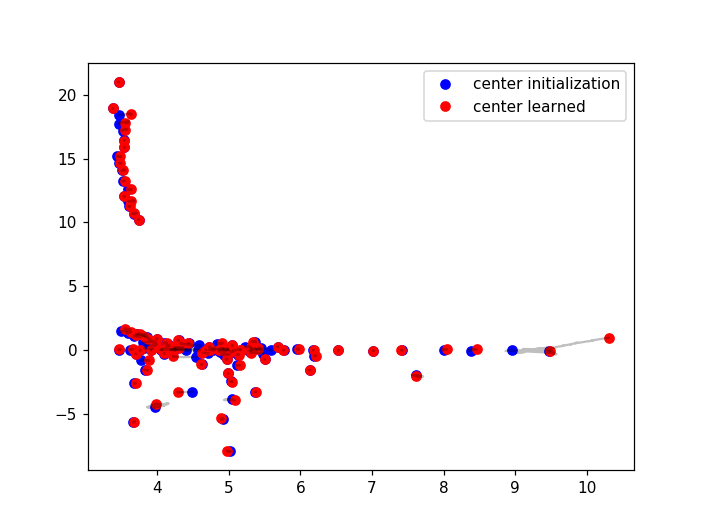

<IPython.core.display.Javascript object>


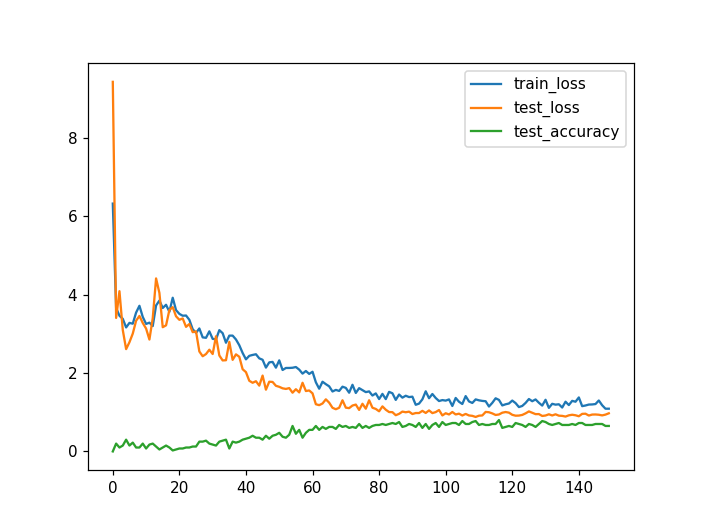

In [6]:

stats = stats_of_runs[0]
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()
